# Air Quality in Houston - Step 5: Model Application #



### Table of Contents

  *  [5.0. One Model, So Many Applications](#section5_0)

  *  [5.1. The Chosen Model, Its Parameters and Performance Metrics](#section5_1)

  *  [5.2. The Model and Climate Change](#section5_2)
         
  *  [5.3. The Final Conclusion](#section5_3)


<a class="anchor" id="section5_0"></a>
## 5.0. One Model, So Many Applications
The Notebook "04_Modeling" shows that the XGBoost Regressor model is the best one to model:
  *  The ozone concentration from pollutant data, weather data, traffic data and population data. (MAE 4.32 and RMSE 6.19).
  *  The ozone concentration from 5 pollutant concentrations (CO, NO2, SO2, PM 2.5, and PM 10) and the maximum temperature (MAE 2.15 and RMSE 4.55).
  *  The ozone concentration using only 1 pollutant, especially with PM 2.5 and NO2 (MAE 5.89 and RMSE 8.16).
  
The main features of importance are:
  *  Maximum outdoor temperature (ozone formation factor)
  *  Pollutants such PM 2.5, NO2, CO (ozone formation factor)
  *  Average windspeed and fastest windspeed (transport factor)
  
   
When comparing these main features to the ingredients involved in ground level ozone formation, which is summarized below in a simplified graph taken from Zhang et al.2019  [ https://www.frontiersin.org/articles/10.3389/fimmu.2019.02518/full], the model handles most ingredients besides the Volatile Organic Compounds (the data contains CO only) and sunlight.

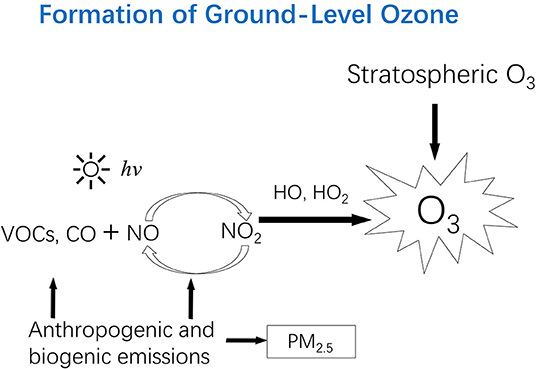

In [190]:
#print(model etrics for other pollutants)
Image(filename = "fimmu-10-02518-g001.jpg", width=500, height=300)

 Adding VOCs and UV data would have certainly benefitiated the model, however, the current results are satisfying.
 
 When it comes to applications the model can be applied to predicting ozone concentration from pollutant data and weather data as shown in 5.1., to predict the concentration of the 4 other pollutants as shown in the modeling, but it can also be used to get an idea of what the ozone concentration would be at higher temperature in the context of climate change as shown in 5.2.

<a class="anchor" id="section5_1"></a>
## 5.1. The Chosen Model, Its Parameters and Performance Metrics

Here are the parameters chosen to tune the XGBoost Regression model:
- boosting rounds:79,
- colsample_bytree & subsample: 1,
- max_depth: 20,
- learning rate (eta): 0.3.

The cross validation of the ozone model shows excellent results with a MAE of 5.8 ug/m3 and a RMSE of 8.1. The MAE is within the expected error measurement from common outdoor sensors which is typically 5 to 10 ug/m3. The model is described below and saved to file "aqh.pickle.dat" in the current folder.

In [191]:
### Import libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error
import pylab as pl
from IPython.display import Image
import seaborn as sns
from sklearn.preprocessing import RobustScaler
import copy
import pickle
import math
import xgboost as xgb

### Location of dataframes and mapping files
path_header='C:\\Users\\Anne\\Documents\\GIT\\TheFoxerine\\'
path_df='CP2_AQ_HOUSTON\\00_SavedDataframes\\'
path_saf='CP2_AQ_HOUSTON\\00_StuffAndThings\\'
path_demog='CP2_AQ_HOUSTON\\00_OriginalData\\DEMOG\\'
path_eda='CP2_AQ_HOUSTON\\02_EDA\\'
path_feat='CP2_AQ_HOUSTON\\03_Feature\\'
path_mod='CP2_AQ_HOUSTON\\04_Modeling\\'

In [192]:
# Import Data
feat_files = {}
path_len=len(path_header+path_feat)
file_extension=len('.csv')

### glob fetches all xls files in the folder ###
allfiles = glob.glob(path_header+path_feat+'feat_*.csv')

### Because Python is all about dictionaries ;) ###
for filename in allfiles:
    df = pd.read_csv(filename,index_col=0)
    filename=filename[path_len::]
    filename_len=len(filename)
    filename=filename[0:(filename_len-file_extension)]
    key_name = str(filename)    
    feat_files[key_name] = copy.deepcopy(df)

### Let's unwrap all df with the correct name
for k,v in feat_files.items():
    globals()[f'{k}'] =v
    
### Let's look at one df, epa_co
feat_ozone.head()

,ozone,temp_max,dust_sand,rain_prcp,smoke_haze,thunder,fog_all,snow_all,rain_all,wind_avgspeed,...,month_November,month_October,month_September,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,39.0,57,0,0.0,0,0,0,0,0,21.03,...,0,0,0,0,0,0,0,0,1,0
9,38.0,50,0,0.0,0,0,0,0,0,18.34,...,0,0,0,0,0,0,0,0,0,1
18,37.0,51,0,0.0,0,0,0,0,0,10.74,...,0,0,0,0,0,0,0,1,0,0
27,35.0,65,0,0.0,0,0,1,1,1,14.54,...,0,0,0,1,0,0,0,0,0,0
36,37.0,71,0,0.0,0,0,1,1,1,10.51,...,0,0,0,0,0,1,0,0,0,0


In [193]:
onepoll=[feat_ozone,feat_co, feat_no2,feat_so2,feat_ozone, feat_pm10]

In [194]:
### create a function that split dataframes into sX,y and train/test sets
def TTS(df,colname):
    X=df.drop(columns=colname, inplace=False)
    y= df[[colname]]
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=13)
    return X,y,X_train,X_test,y_train,y_test

In [195]:
### train/test split
X_ozone, y_ozone, X_ozone_train, X_ozone_test, y_ozone_train, y_ozone_test=TTS(feat_ozone,'ozone')
X_co, y_co, X_co_train, X_co_test, y_co_train, y_co_test=TTS(feat_co,'co')
X_no2, y_no2, X_no2_train, X_no2_test, y_no2_train, y_no2_test=TTS(feat_no2,'no2')
X_so2, y_so2, X_so2_train, X_so2_test, y_so2_train, y_so2_test=TTS(feat_so2,'so2')
X_pm25, y_pm25, X_pm25_train, X_pm25_test, y_pm25_train, y_pm25_test=TTS(feat_pm25,'pm25')
X_pm10, y_pm10, X_pm10_train, X_pm10_test, y_pm10_train, y_pm10_test=TTS(feat_pm10,'pm10')

In [196]:
### scale X
ozone_scaler=RobustScaler()
X_ozone_train_scaled=ozone_scaler.fit_transform(X_ozone_train)
X_ozone_test_scaled=ozone_scaler.transform(X_ozone_test)

co_scaler=RobustScaler()
X_co_train_scaled=co_scaler.fit_transform(X_co_train)
X_co_test_scaled=co_scaler.transform(X_co_test)

no2_scaler=RobustScaler()
X_no2_train_scaled=no2_scaler.fit_transform(X_no2_train)
X_no2_test_scaled=no2_scaler.transform(X_no2_test)

so2_scaler=RobustScaler()
X_so2_train_scaled=so2_scaler.fit_transform(X_so2_train)
X_so2_test_scaled=so2_scaler.transform(X_so2_test)

pm25_scaler=RobustScaler()
X_pm25_train_scaled=pm25_scaler.fit_transform(X_pm25_train)
X_pm25_test_scaled=pm25_scaler.transform(X_pm25_test)

pm10_scaler=RobustScaler()
X_pm10_train_scaled=pm10_scaler.fit_transform(X_pm10_train)
X_pm10_test_scaled=pm10_scaler.transform(X_pm10_test)

In [197]:
### preparing DMatrix
ozone_dmx=xgb.DMatrix(data=X_ozone, label=y_ozone)
co_dmx=xgb.DMatrix(data=X_co, label=y_co)
no2_dmx=xgb.DMatrix(data=X_no2, label=y_no2)
so2_dmx=xgb.DMatrix(data=X_so2, label=y_so2)
pm25_dmx=xgb.DMatrix(data=X_pm25, label=y_pm25)
pm10_dmx=xgb.DMatrix(data=X_pm10, label=y_pm10)

In [198]:
tree_para_ozone = {'objective':'reg:squarederror','booster':'gbtree', 
             'n_estimators':1000, 'max_depth':20, 
             'colsample_bytree':1, 'subsample':1, 'eta':0.3}
nfold=10
boost=79
rmse_cv_ozone = xgb.cv(dtrain=ozone_dmx, params=tree_para_ozone , nfold=nfold, num_boost_round=boost, metrics='rmse', as_pandas=True, seed=13)
rmse_ozone=rmse_cv_ozone['test-rmse-mean'].tail().values[-1]
mae_cv_ozone= xgb.cv(dtrain=ozone_dmx, params=tree_para_ozone , nfold=nfold, num_boost_round=boost, metrics='mae', as_pandas=True, seed=13)
mae_ozone=mae_cv_ozone['test-mae-mean'].tail().values[-1]

[19:46:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:46:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:46:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in la

[19:52:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


O3 model MAE 4.32 and RMSE 6.19


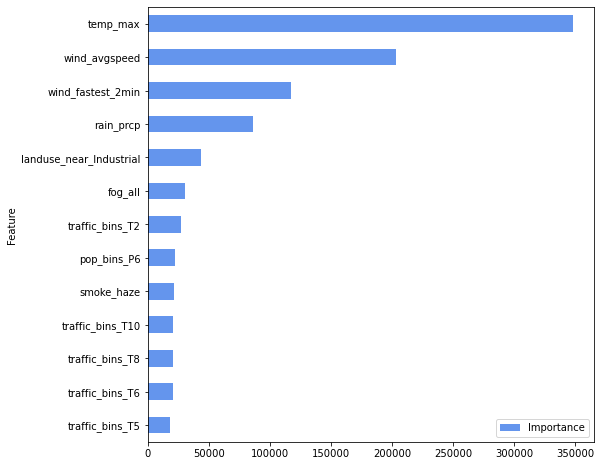

In [199]:
# Plot the feature importances
xgb_final_ozone = xgb.train(dtrain=ozone_dmx, params=tree_para_ozone , num_boost_round=100)
features_ozone = xgb_final_ozone.get_fscore()
impfeat_ozone = pd.DataFrame({'Importance': list(features_ozone.values()), 'Feature': list(features_ozone.keys())})
impfeat_ozone.sort_values(by = 'Importance', inplace = True, ascending = True)
impfeat_ozone.tail(13).plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'cornflowerblue')
print('O3 model MAE',round(mae_ozone,2), 'and RMSE', round(rmse_ozone,2))

The cosen model has a MAE of 4.32 and RMSE of 6.19 which are within the measured error range.
The major features of importance of the ozone model are:
- the first feature is the maximum temperature, which is a catalyst in the formation of ozone.
- the second and third features are the wind, which transports the ozone away from its source and  is the reason why ozone can be found in remote country areas.
- the fourth feature is the amount of rain precipitation, which is interesting because rainy days tend to be less polluted because the pollutants are washed away by the rain. This phenomenon is called 'wet deposition'. Here the influence of rain will have to be determined: is it washing away pollution or washing it in?
- the fifth feature is industrial activity. Note that the pollution is not in the industrial zone, but 'near' it, which story works well with the influence of the  wind and the rain on ozone formation.

The minor features are a mix of foggy/hazy weather, traffic and population.

I performed the same type of parameters search for the other five pollutants and came up with the following parameters and results (the code can be found in section 04_Modeling):

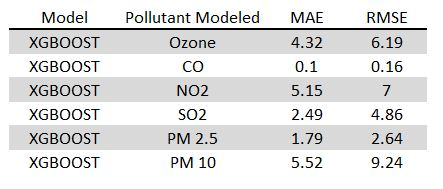

In [200]:
# show model metrics obtained for the other pollutants
Image(filename = "aqh_model_metrics.jpg", width=300, height=270)

Now let's apply the model and visualize the difference between test and predicted ozone concentrations.

In [201]:
xgb_ozone = xgb.XGBRegressor(colsample_bytree = 1, learning_rate = 0.3,max_depth = 20)

xgb_ozone.fit(X_ozone_train,y_ozone_train)

predicted_ozone = xgb_ozone.predict(X_ozone_test)

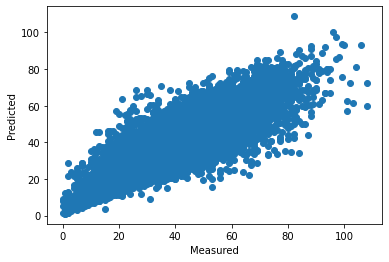

MAE: 4.6
RMSE: 6.5


In [202]:
fig, ax = plt.subplots()
ax.scatter(y_ozone_test, predicted_ozone)

ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

print('MAE:', round(mean_absolute_error(y_ozone_test, predicted_ozone),1))
print('RMSE:',round(np.sqrt(mean_squared_error(y_ozone_test, predicted_ozone)),1))

It does not look good but just as expected when considering the MAE and RMSE 

The model is saved using the pickle API.

In [203]:
# save model to file
pickle.dump(xgb_ozone, open("aqh.pickle.dat", "wb"))


<a class="anchor" id="section5_2"></a>
## 5.2. The Model and Climate Change
Climate change is the problem of this century and probably the next. What would be the impact of increased tempartures on the formation of ozone in Houston?
Let's find out!

In [213]:
# First add heat and wind in the train test
del X_ozone_veryHOTtest
del X_ozone_HOTtest

X_ozone_HOTtest = X_ozone_test.copy()
X_ozone_veryHOTtest = X_ozone_test.copy()
X_ozone_windy_test = X_ozone_test.copy()

X_ozone_HOTtest['temp_max'] = X_ozone_HOTtest['temp_max']+10
X_ozone_veryHOTtest['temp_max'] = X_ozone_veryHOTtest['temp_max']+20

X_ozone_windy_test['wind_avgspeed'] = X_ozone_windy_test['wind_avgspeed']*2

In [214]:
X_ozone_test

,temp_max,dust_sand,rain_prcp,smoke_haze,thunder,fog_all,snow_all,rain_all,wind_avgspeed,wind_fastest_2min,...,month_November,month_October,month_September,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
157014,89,0,0.00,0,0,0,0,0,5.59,14.1,...,0,0,0,0,1,0,0,0,0,0
1086602,46,0,0.00,0,0,0,0,0,9.84,18.1,...,0,0,0,1,0,0,0,0,0,0
819253,64,0,0.66,0,0,1,1,1,12.53,19.9,...,0,1,0,0,0,0,0,0,1,0
665132,97,0,0.00,0,1,0,0,0,5.14,17.0,...,0,0,0,0,1,0,0,0,0,0
124878,78,0,0.00,0,0,0,0,0,13.65,25.1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,73,0,0.00,0,0,1,1,1,10.96,17.0,...,0,0,0,0,1,0,0,0,0,0
432065,80,0,0.13,0,0,1,1,1,8.28,18.1,...,0,0,0,0,0,0,0,0,0,1
666748,98,0,0.00,0,0,0,0,0,5.59,16.1,...,0,0,0,0,0,0,0,0,0,1
905714,65,0,0.00,1,0,1,1,1,8.05,15.0,...,0,0,0,0,1,0,0,0,0,0


In [215]:
# let's pretend the model does not already exist in this notebook ;)
## load model from file
aqh_model = pickle.load(open("aqh.pickle.dat", "rb"))


In [216]:
# run it through the model
predicted_HOTozone = aqh_model.predict(X_ozone_HOTtest)

predicted_veryHOTozone = aqh_model.predict(X_ozone_veryHOTtest)

predicted_windy_ozone = aqh_model.predict(X_ozone_windy_test)

print('Minimum Ozone Concentration Prediction when the temperature is increased by 10F: ', round(predicted_HOTozone.min(),0))
print('Maximum Ozone Concentration Prediction when the temperature is increased by 10F: ', round(predicted_HOTozone.max(),0))
print('Average Ozone Concentration Prediction when the temperature is increased by 10F: ', round(predicted_HOTozone.mean(),0))

print('Minimum Ozone Concentration Prediction when the temperature is increased by 20F: ', round(predicted_veryHOTozone.min(),0))
print('Maximum Ozone Concentration Prediction when the temperature is increased by 20F: ', round(predicted_veryHOTozone.max(),0))
print('Average Ozone Concentration Prediction when the temperature is increased by 20F: ', round(predicted_veryHOTozone.mean(),0))

print('Minimum Ozone Concentration Prediction with twice more wind: ', round(predicted_windy_ozone.min(),0))
print('Maximum Ozone Concentration Prediction with twice more wind: ', round(predicted_windy_ozone.max(),0))
print('Average Ozone Concentration Prediction with twice more wind: ', round(predicted_windy_ozone.mean(),0))

Minimum Ozone Concentration Prediction when the temperature is increased by 10F:  6.0
Maximum Ozone Concentration Prediction when the temperature is increased by 10F:  125.0
Average Ozone Concentration Prediction when the temperature is increased by 10F:  41.0
Minimum Ozone Concentration Prediction when the temperature is increased by 20F:  8.0
Maximum Ozone Concentration Prediction when the temperature is increased by 20F:  110.0
Average Ozone Concentration Prediction when the temperature is increased by 20F:  44.0
Minimum Ozone Concentration Prediction with twice more wind:  2.0
Maximum Ozone Concentration Prediction with twice more wind:  89.0
Average Ozone Concentration Prediction with twice more wind:  30.0


In [208]:
print('Measured Ozone Concentration Test Maximum: ', round(y_ozone_test.max(),0))

Measured Ozone Concentration Test Maximum:  ozone    108.0
dtype: float64


In the test set the maximum ozone concetration is 108 ug/m3 which is considered "Unhealthy". When increasing the temperature uniformally by 10F in the test set, the maximum ozone concentration is predicted to be 125 ug/m3 which is 17 ug/m3 more than in the test set and is considered "Very Unhealthy". When increasing the temperature by 20F the maximum ozone concentration is predicted to be similar to the test set. Double the average wind speed in the test set to see the maximum concentration decrease by 20 ug/m3 to be "Unhealthy for Sensitive Groups".
In other word, the model predicts there is a threshold of temperature beyond which temperature alone cannot increase the concentration of ozone and that the wind, if strong enough, may push the ozone problem away.

<a class="anchor" id="section5_4"></a>
## 5.4. The Final Conclusion
I think it is very difficult for data scientists to avoid being biased by the data and their personal opinion or experience when preparing datasets to build a model. I am sure my bias came from the many hours during which I got stuck in traffic in Houston, the many hours of small talk about traffic, and the numerous and recurring news and headlines about traffic, haze, smog...etc... 
The data said "No".
The model said "Let me show you what it is about".
Using the XGB Regressor, the results could have been better if the data was just focussed on collecting pollutant, including VOCs, and weather data, skipping population and traffic. Even if the metrics of the model are not great, though still within measurement error, it is a  relief to see the limited power of heat on ozone formation, in that more heat does not mean more ozone and therefore the source of "chemical ingredients" should be controlled. On the other hand the dual role of the wind which can either bring the ozone problem in Houston or push it away is much more interesting.
Forecasts for Houston predict more people, more traffic, more heat, more industrial activity... maybe Houston also needs more wind ;)